In [1]:
#################### Neural Networks (Regression) ####################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



#################### Hyperparameters
epoch = 300
etta = 0.01
train_rate = 0.7
val_rate = 0.1
test_rate = 0.2

L = 2
D = {1:2, 2:1}



#################### Loading Dataset and Preprocessing
df = pd.read_csv("data/usa-housing.csv")

col_dic = {"Avg. Area Income": "Avg. Income", "Avg. Area House Age": "Avg. Age", "Avg. Area Number of Rooms": "Avg. Rooms",
          "Avg. Area Number of Bedrooms": "Avg. Bedrooms", "Area Population": "Population"}

df.rename(columns=col_dic, inplace=True)
df = df.drop(['Address'], axis = 1)
data = np.array(df)
M,N = np.shape(data)



def standardisation(data):
    out = (data - np.mean(data, axis=0))/ np.std(data, axis=0)
    return out


def normalisation(data):
    m = np.min(data, axis=0)
    M = np.max(data, axis=0)
    out = (data - m) / (M - m)
    return out


data = standardisation(data)
data = np.hstack((np.ones((M,1)), data))


In [2]:
#################### Train-Test-Validation Split
M_train = int(np.ceil(train_rate * M))
M_val = int(np.ceil(val_rate * M))
M_test = M - (M_train + M_val)

idx = np.random.permutation(M)
train_idx = idx[:M_train]
val_idx = idx[M_train: M_train + M_val]
test_idx = idx[M_train + M_val:]

X_train = data[train_idx, :-1]
Y_train = data[train_idx, -1]
X_val = data[val_idx, :-1]
Y_val = data[val_idx, -1]
X_test = data[test_idx, :-1]
Y_test = data[test_idx, -1]


In [3]:
#################### Functions (The Model)
def m(x):
    if x > 0:
        return x
    else:
        return 0


def relu(x):
    out = np.max((0,x))
    return out


def sigmoid(X):
    n = np.apply_along_axis(np.exp, 1, -1*X)
    out = 1 / (1 + n)
    return out


def softmax(X):
    new = np.apply_along_axis(np.exp, 1, X)
    D = np.sum(new, axis=1)
    new2 = np.apply_along_axis(np.exp, 1, X)
    S = new2/D[:, np.newaxis]
    return S


def grad_softmax(X):
    s = softmax(X)
    out = s - s**2
    return out



def grad_sigmoid(X):
    p1 = sigmoid(X)
    out = p1 - (p1**2)
    #out = np.hstack((np.zeros((n,1)), out))
    return out



def perceptron(X,W):
    l = X @ W
    out = relu(l)
    return out




#################### Functions (Test and Validation)

def MSE(Y, Y_hat, n):
    error = (1/n) * (Y - Y_hat)**2
    out = np.sum(error) 
    return out


def RMSE(Y, Y_hat, n):
    error = (1/n) * (Y - Y_hat)**2
    out = np.sum(error) 
    return np.sqrt(out)


def MAE(Y, Y_hat, n):
    error = (1/n) * np.abs(Y - Y_hat)
    out = np.sum(error)
    return out


def grad(X, Y, Y_hat, n):
    grad = (2/n) * (np.transpose(X) @ (Y_hat - Y))
    return grad



def R2(Y, Y_hat, n):
    s1 = np.sum((Y - Y_hat)**2)
    s2 = np.sum((Y - np.mean(Y_hat))**2)
    out = 1 - (s1/s2)
    return out


def cost_func(Y, Y_hat, n):
    new = np.apply_along_axis(np.exp, 1, Y_hat)
    D = np.sum(new, axis=1)
    new2 = np.apply_along_axis(np.exp, 1, Y_hat)
    S = new2/D[:, np.newaxis]
    Z = np.log(S) @ np.transpose(Y)
    out = (-1/n) * np.sum(Z)
    return out


In [4]:
#################### Neural Network Model
X = dict()
X_1 = dict()
X_2 = dict()
W = dict()
S = dict()
S_val = dict()
S_test = dict()
delta = dict()
G = dict()

X[0] = X_train
X_1[0] = X_val
X_2[0] = X_test
Y_train = np.reshape(Y_train, (M_train,1))
Y_val = np.reshape(Y_val, (M_val, 1))
Y_test = np.reshape(Y_test, (M_test,1))



for l in range(1,L+1):
    if l == 1:
        W[l] = np.random.rand(N, D[l])
    else:
        W[l] = np.random.rand(D[l-1]+1, D[l])
        
        


In [5]:
        
L_train = np.array([])
L_val = np.array([])


for i in range(epoch):    

    for l in range(1,L+1):
        S[l] = X[l-1] @ W[l]
        S_val[l] = X_1[l-1] @ W[l]
        if l < L:
            f = np.vectorize(relu)
            new_array = f(S[l])
            X[l] = np.hstack((np.ones((M_train,1)), new_array))
            
            new_array_2 = f(S_val[l])
            X_1[l] = np.hstack((np.ones((M_val,1)), new_array_2))
        else:
            f = np.vectorize(relu)
            X[l] = f(S[l])
            X_1[l] = f(S_val[l])
    
    c_train = MSE(Y_train, X[L], M_train)
    L_train = np.append(L_train, c_train)
    
    c_val = MSE(Y_val, X_1[L], M_val)
    L_val = np.append(L_val, c_val)
    
        
    for l in range(L, 0, -1):
        if l < L:
            m,j = np.shape(grad_sigmoid(S[l]))
            arr = delta[l+1] @ np.transpose(W[l+1])
            delta[l] = 2 * grad_sigmoid(S[l]) * (arr[:, :j])
        else:
            delta[l] = 2 * grad_sigmoid(S[l]) * (X[l] - Y_train)
        
        
        
    for l in range(1, L+1):
        G[l] = (1/M_train) * (np.transpose(X[l-1]) @ delta[l])

    

    for l in range(1, L+1):
        W[l] = W[l] - (etta * G[l])
    
    
      


#################### Test and Validation

MSE_train = L_train[-1]
MSE_val = L_val[-1]



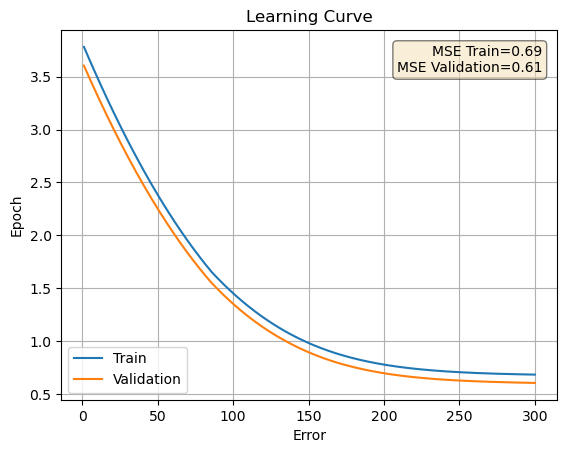

The MSE of Train Is:  0.6863990997701497
The MSE of Validation Is:  0.6079543460894905


In [6]:
# Learning Curve

fig, ax = plt.subplots()

plt.plot(range(1, epoch+1), L_train, label='Train')
plt.plot(range(1, epoch+1), L_val, label='Validation')
plt.title("Learning Curve")
plt.xlabel("Error")
plt.ylabel("Epoch")
plt.grid()
plt.legend(loc="lower left")

txt = '\n'.join((
    r'MSE Train=%.2f' % (MSE_train, ),
    r'MSE Validation=%.2f' % (MSE_val, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(0.97, 0.96, txt, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props)



plt.show()

print("The MSE of Train Is: ", MSE_train)
print("The MSE of Validation Is: ", MSE_val)
